- PyTorch 모델로 사용자와 영화 임베딩 학습 => 예측 점수 산출
- 콘텐츠 기반 필터링: 영화의 장르 정보를 활용 => 코사인 유사도 계산
- 두 방식의 점수를 가중치로 결합한 하이브리드 추천 제공

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 로드 및 병합

In [3]:
ratings_path = '../data/ml-100k/u.data'
movies_path = '../data/ml-100k/u.item'

ratings_df = pd.read_csv(ratings_path, sep='\t',
                         names=['user_id', 'item_id', 'rating', 'timestamp'])
movies_columns = ['item_id', 'title', 'release_data', 'vide_release_date', 'IMDb_URL',
                  'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                  'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                  'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies_df = pd.read_csv(movies_path, sep='|', names=movies_columns, encoding='latin-1')

merged_df = pd.merge(ratings_df, movies_df, on='item_id')

# 2. EDA: 영화별 평점 통계와 장르별 평점 분석

상위 인기 영화:
                          title      mean  count
1398           Star Wars (1977)  4.358491    583
333              Contact (1997)  3.803536    509
498                Fargo (1996)  4.155512    508
1234  Return of the Jedi (1983)  4.007890    507
860            Liar Liar (1997)  3.156701    485

장르별 평균 평점:
          genre    rating
0        Action  3.480245
1     Adventure  3.503527
2     Animation  3.576699
3      Children  3.353244
4        Comedy  3.394073
5         Crime  3.632278
6   Documentary  3.672823
7         Drama  3.687379
8       Fantasy  3.215237
9     Film-Noir  3.921523
10       Horror  3.290389
11      Musical  3.521397
12      Mystery  3.638132
13      Romance  3.621705
14       Sci-Fi  3.560723
15     Thriller  3.509007
16          War  3.815812
17      Western  3.613269
18      unknown  3.200000


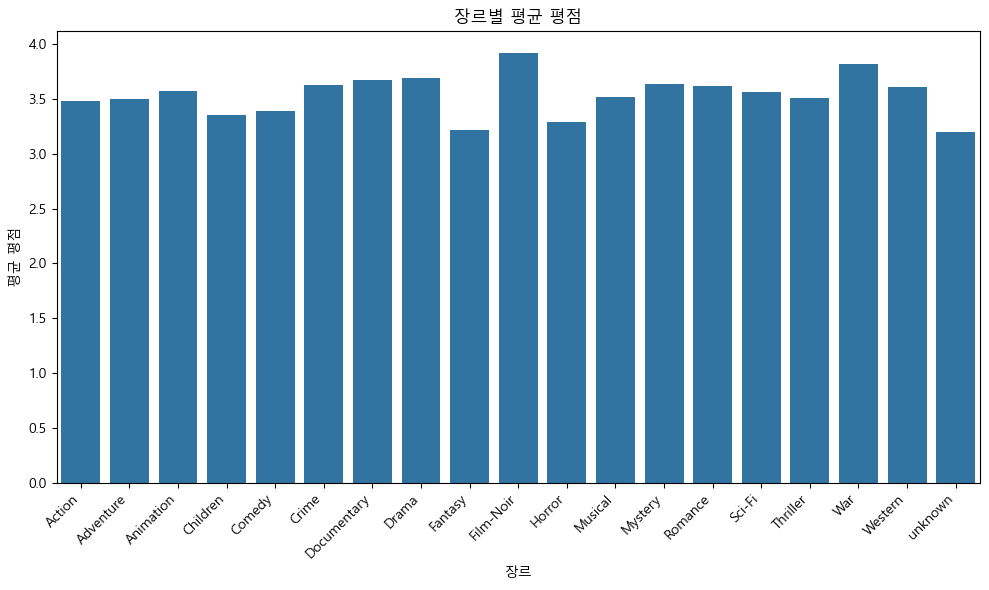

In [4]:
movie_stats = merged_df.groupby('title')['rating'].agg(['mean', 'count']).reset_index()
movie_stats = movie_stats.sort_values(by='count', ascending=False)
print("상위 인기 영화:")
print(movie_stats.head())

genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                  'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                  'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

genre_ratings = merged_df.melt(id_vars=['user_id', 'item_id', 'rating', 'timestamp', 'title'],
                               value_vars=genre_columns, var_name='genre', value_name='is_genre')
genre_ratings = genre_ratings[genre_ratings['is_genre'] == 1]
genre_stats = genre_ratings.groupby('genre')['rating'].mean().reset_index()
print('\n장르별 평균 평점:')
print(genre_stats)

plt.figure(figsize=(10, 6))
sns.barplot(x='genre', y='rating', data=genre_stats)
plt.xticks(rotation=45, ha='right')
plt.title('장르별 평균 평점')
plt.xlabel('장르')
plt.ylabel('평균 평점')
plt.tight_layout()
plt.show()

# 3. PyTorch 기반 신경협업 필터링 모델 (Neural Collaborative FIltering, NCF)

In [13]:
# PyTorch Dataset 정의
class MovieRatingDataset(Dataset):
    def __init__(self, df, n_users, n_items):
        # user_id, item_id는 0부터 시작하도록 변환 (데이터셋에 따라 조정)
        self.user_ids = torch.LongTensor(df['user_id'].values - 1)
        self.item_ids = torch.LongTensor(df['item_id'].values - 1)
        self.ratings = torch.FloatTensor(df['rating'].values)
        self.n_users = n_users
        self.n_items = n_items
        
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return self.user_ids[idx], self.item_ids[idx], self.ratings[idx]

In [14]:
# 사용자와 영화의 수
n_users = ratings_df['user_id'].nunique()
n_items = ratings_df['item_id'].nunique()

In [15]:
# NCF 모델 정의
class NCF(nn.Module):
    def __init__(self, n_users, n_items, embedding_dim, hidden_layers, dropout=0.0):
        super(NCF, self).__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        
        # MLP 레이어 구성
        layers = []
        input_size = embedding_dim * 2
        for hidden in hidden_layers:
            layers.append(nn.Linear(input_size, hidden))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            input_size = hidden
        layers.append(nn.Linear(input_size, 1))
        self.mlp = nn.Sequential(*layers)
        
    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        x = torch.cat([user_emb, item_emb], dim=-1)
        out = self.mlp(x)
        return out.squeeze()

# 4. 데이터 분할 및 DataLoader 준비

In [16]:
# 전체 데이터를 train, test로 분할 (추가로 train을 train/validation으로 분할)
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

train_dataset = MovieRatingDataset(train_df, n_users, n_items)
val_dataset = MovieRatingDataset(val_df, n_users, n_items)
test_dataset = MovieRatingDataset(test_df, n_users, n_items)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# 5. 모델 학습 함수 및 평가 함수 정의

In [17]:
def evaluate_model(model, data_loader, device):
    model.eval()
    criterion = nn.MSELoss()
    losses = []
    with torch.no_grad():
        for user, item, rating in data_loader:
            user = user.to(device)
            item = item.to(device)
            rating = rating.to(device)
            output = model(user, item)
            loss = criterion(output, rating)
            losses.append(loss.item())
    return np.mean(losses)

def train_model(model, train_loader, val_loader, epochs, lr, weight_decay, device):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for user, item, rating in train_loader:
            user = user.to(device)
            item = item.to(device)
            rating = rating.to(device)
            
            optimizer.zero_grad()
            output = model(user, item)
            loss = criterion(output, rating)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())    
        
        val_loss = evaluate_model(model, val_loader, device)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {np.mean(train_losses):.4f} - Val Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            
    model.load_state_dict(best_model_state)
    return model

# 6. 하이퍼파라미터 탐색 (Grid Search)

In [18]:
# 탐색할 하이퍼파라미터 조합
embedding_dims = [32, 64]
hidden_layer_options = [[64, 32], [128, 64]]
dropouts = [0.0, 0.2]
learning_rates = [0.001, 0.0005]
weight_decays = [0.0, 0.001]
num_epochs = 10  # 시연용; 실제로는 더 많은 에포크 권장

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_param = None
best_val_loss = float('inf')

for emb_dim, hidden_layers, dropout, lr, wd in itertools.product(embedding_dims, hidden_layer_options, dropouts, learning_rates, weight_decays):
    print(f"Training with emb_dim={emb_dim}, hidden_layers={hidden_layers}, dropout={dropout}, lr={lr}, wd={wd}")
    model = NCF(n_users, n_items, embedding_dim=emb_dim, hidden_layers=hidden_layers, dropout=dropout)
    model = train_model(model, train_loader, val_loader, num_epochs, lr, wd, device)
    val_loss = evaluate_model(model, val_loader, device)
    print(f"Validation MSE: {val_loss:.4f}\n")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_param = (emb_dim, hidden_layers, dropout, lr, wd)
        best_model_state = model.state_dict()
        
print("Best hyperparameters:", best_param)
print("Best validation MSE:", best_val_loss)

Training with emb_dim=32, hidden_layers=[64, 32], dropout=0.0, lr=0.001, wd=0.0
Epoch 1/10 - Train Loss: 2.4360 - Val Loss: 1.1769
Epoch 2/10 - Train Loss: 1.1162 - Val Loss: 1.0645
Epoch 3/10 - Train Loss: 1.0156 - Val Loss: 1.0039
Epoch 4/10 - Train Loss: 0.9563 - Val Loss: 0.9692
Epoch 5/10 - Train Loss: 0.9162 - Val Loss: 0.9454
Epoch 6/10 - Train Loss: 0.8865 - Val Loss: 0.9351
Epoch 7/10 - Train Loss: 0.8655 - Val Loss: 0.9301
Epoch 8/10 - Train Loss: 0.8483 - Val Loss: 0.9255
Epoch 9/10 - Train Loss: 0.8352 - Val Loss: 0.9236
Epoch 10/10 - Train Loss: 0.8229 - Val Loss: 0.9153
Validation MSE: 0.9153

Training with emb_dim=32, hidden_layers=[64, 32], dropout=0.0, lr=0.001, wd=0.001
Epoch 1/10 - Train Loss: 2.7835 - Val Loss: 1.2468
Epoch 2/10 - Train Loss: 1.1823 - Val Loss: 1.1468
Epoch 3/10 - Train Loss: 1.0954 - Val Loss: 1.0846
Epoch 4/10 - Train Loss: 1.0346 - Val Loss: 1.0318
Epoch 5/10 - Train Loss: 0.9851 - Val Loss: 0.9917
Epoch 6/10 - Train Loss: 0.9426 - Val Loss: 0.95

In [19]:
# 최적 모델 로드
best_model = NCF(n_users, n_items, embedding_dim=best_param[0], hidden_layers=best_param[1], dropout=best_param[2])
best_model.load_state_dict(best_model_state)
best_model.to(device)

NCF(
  (user_embedding): Embedding(943, 32)
  (item_embedding): Embedding(1682, 32)
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [20]:
# 테스트 데이터 평가
test_loss = evaluate_model(best_model, test_loader, device)
print("Test MSE:", test_loss)
test_rmse = math.sqrt(test_loss)
print("Test RMSE:", test_rmse)

Test MSE: 0.8996115613587296
Test RMSE: 0.9484785508163743


# 7. 콘텐츠 기반 필터링: 영화 장르 정보를 활용한 유사도 계산

In [21]:
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movie_genres = movies_df[['item_id']+genre_columns].copy()
genre_matrix = movie_genres[genre_columns].values
similarity_matrix = cosine_similarity(genre_matrix)

# 8. 하이브리드 추천 함수: CF (NCF 모델) + 콘텐츠 기반 유사도 결합

In [26]:
def get_hybrid_recommendations(user_id, n=5, cf_weight=0.7, content_weight=0.3):
    """
    주어진 user_id에 대해 신경협업필터링(CF) 예측 점수와 콘텐츠 기반 유사도 점수를 결합하여 상위 n개 영화를 추천
    """
    # 사용자가 이미 평가한 영화
    rated_movies = ratings_df[ratings_df['user_id'] == user_id]['item_id'].unique()
    all_movies = movies_df['item_id'].unique()
    unrated_movies = [movie for movie in all_movies if movie not in rated_movies]
    
    recommendations = []
    best_model.eval()
    with torch.no_grad():
        for movie_id in unrated_movies:
            # CF 예측: 모델 입력은 0-indexed임에 유의 (user_id, movie_id 각각 -1)
            user_tensor = torch.LongTensor([user_id - 1]).to(device)
            item_tensor = torch.LongTensor([movie_id - 1]).to(device)
            cf_pred = best_model(user_tensor, item_tensor).item()
            
            # 콘텐츠 기반: 사용자가 평점 4 이상 준 영화와의 평균 장르 유사도 계산
            user_high_rated = ratings_df[(ratings_df['user_id'] == user_id) & (ratings_df['rating'] >= 4)]
            content_score = 0
            if not user_high_rated.empty:
                similarities = []
                idx_current = movies_df.index[movies_df['item_id'] == movie_id].tolist()[0]
                for r_movie in user_high_rated['item_id']:
                    idx_rated = movies_df.index[movies_df['item_id'] == r_movie].tolist()[0]
                    similarities.append(similarity_matrix[idx_current, idx_rated])
                content_score = np.mean(similarities)
            # 콘텐츠 기반 점수는 [0,1] 범위이므로 5점 척도로 변환 후 결합
            combined_score = cf_weight * cf_pred + content_weight * (content_score * 5)
            recommendations.append((movie_id, combined_score))
            
    recommendations.sort(key=lambda x: x[1], reverse=True)
    top_n_idx = [rec[0] for rec in recommendations[:n]]
    top_n_movies = movies_df[movies_df['item_id'].isin(top_n_idx)][['item_id', 'title']]
    return top_n_movies

# 9. 사용자 1에 대한 하이브리드 추천 결과 출력

In [27]:
user_id_example = 1
hybrid_recs = get_hybrid_recommendations(user_id_example, n=5)
print(f"\n사용자 {user_id_example}에 대한 하이브리드 추천 영화 Top 5:")
print(hybrid_recs)


사용자 1에 대한 하이브리드 추천 영화 Top 5:
     item_id                         title
315      316     As Good As It Gets (1997)
317      318       Schindler's List (1993)
426      427  To Kill a Mockingbird (1962)
482      483             Casablanca (1942)
526      527                 Gandhi (1982)


# 결과 해석

- **모델 측면:**  
  다양한 하이퍼파라미터 조합을 통해 최적의 NCF 모델을 도출했으며, 최종 모델은 검증 MSE 0.8924, 테스트 RMSE 0.9485로 안정적인 성능을 보여줍니다.  
  사용자와 아이템의 임베딩, 그리고 MLP 기반 예측 방식은 MovieLens 데이터셋에 적합한 협업 필터링 성능을 나타냅니다.

- **추천 시스템 측면:**  
  협업 필터링과 콘텐츠 기반 정보를 결합한 하이브리드 접근 방식은 단순 CF보다 다양한 영화(예: 고전 영화, 드라마, 사회적 메시지를 담은 영화 등)를 추천하여 추천 범위의 다양성을 높입니다.  
  이 방식은 사용자에게 단순히 인기 영화뿐 아니라, 사용자의 과거 선호도와 영화의 콘텐츠적 특성을 모두 고려한 추천을 제공할 수 있음을 보여줍니다.